In [1]:
import sys
import os
import itertools as it
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn import decomposition as skd
from sklearn import feature_extraction as skfe
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import gensim
from gensim.models.doc2vec import TaggedDocument
import re
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
import wikipedia
import difflib
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')

wikipedia.set_lang('en')



In [2]:
sys.path.insert(1, '../')

In [3]:
from src.data import journalists as journos
from src.data import data_cleanup as dc
from src.topics import hashtag_analysis as ha

In [ ]:
!pip install gensim==3.8.3

In [ ]:
!pip install wikipedia

In [4]:
#import data

src_dir = r'C:\Users\elizabeth\Documents\cleaned tweets\cyber friends tweets'

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))] # build list of files to iterate through

data = pd.DataFrame()

with tqdm(total=len(files), desc='Files') as pbar:
    for file in files:
        df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        data = pd.concat([data, df[['tweet_id', 'text', 'hashtags']]], axis=0)
        pbar.update(1)
        
data = data[data['hashtags'].astype(str) != '[]'] # remove empties
data['text'] = data['text'].apply(lambda x: x.lower() if isinstance(x, str) else '')
data = data[data.text != '']

Files: 100%|███████████████████████████████████████████████████████████████████████████| 40/40 [02:12<00:00,  3.31s/it]


In [5]:
hashtag_observations = ha.vectorize_wordlists(data['hashtags'])
hashtag_observations.info()
hashtag_observations.sparse.density

<class 'pandas.core.frame.DataFrame'>
Int64Index: 722766 entries, 1 to 87447
Columns: 217116 entries, 00050c to 𝙏𝙐𝙀𝙎𝘿𝘼𝙔𝙏𝙐𝙉𝙀𝙎
dtypes: Sparse[int64, 0](217116)
memory usage: 21.7 MB


9.012709550464738e-06

Sum of the explained variance = 0.189.


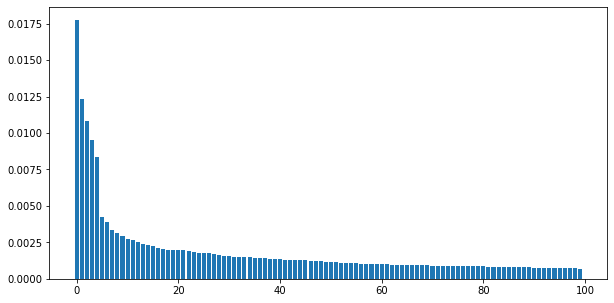

In [6]:
hashtag_dimred, svd_comps = ha.SVD_on_vectors(hashtag_observations, n_components=100)

In [7]:
topics = ha.make_topic_keywords_from_svd(svd_comps, threshold=0.2)
topics

,keywords
topic,
0,[covid19]
1,"[ai, cybersecurity, fintech]"
2,"[cybersecurity, infosec]"
3,[fintech]
4,[coronavirus]
...,...
95,"[economy, insurance, iran, sustainability]"
96,"[mondaymotivation, sustainability]"
97,"[mentalhealth, mondaymotivation]"


In [32]:
topics = [['covid19', 'lockdown', 'coronavirus'],
            ['ai', 'ml', 'datascience', 'artificalintelligence', 'machinelearning', 'bigdata'], 
            ['cybersecurity', 'iot', 'robotics', 'infosec'],
            ['fintech', 'blockchain', 'payments', 'cryptocurrency', 'bitcoin', 'cyrpto', 'banking'],
            ['brexit'],
            ['startup', 'startups'],
            ['china'],
            ['blacklivesmatter'],
          ['malware', 'ransomware', 'phising'],
              ['environment', 'health', 'mentalhealth', 'research'],
          ['beirut', 'belarus', 'lebanon'],
          ['jobs', 'journalism', 'tourism', 'travel'],
          ['property', 'realestate'],
          ['gdpr', 'insurance', 'insurtech'],
          ['climatechange', 'esg', 'sustainability'],
          ['oil', 'oott', 'opec', 'russia']]

#### assign topics to tweets

In [33]:
def check_for_matches(tag_list, topic_list):
    '''
    
    '''
    matches = []
    
    # Compare list of hashtags in tweet against those in each topic
    potential_matches = [bool(set(tag_list).intersection(set(topic))) for topic in topics]
    if any(potential_matches):
        matches.extend([i for i in range(len(potential_matches)) if potential_matches[i]])
    else:
        matches.append(16)
    return matches

possible_topics = data['hashtags'].apply(lambda x: check_for_matches(eval(x), topics))

labelled_data = data.assign(topic_labels=possible_topics.values)
labelled_data['main_label'] = labelled_data['topic_labels'].apply(lambda x: x[0])
labelled_data

,tweet_id,text,hashtags,topic_labels,main_label
1,1293934001514848256,rt breaking via fbi to join beirut blast probe...,"['breaking', 'fbi', 'beirut', 'probe']",[10],10
2,1293580602055299072,rt breaking lebanon prosecutor to question sev...,"['breaking', 'beirutblast']",[16],16
6,1292021027543953408,rt according to the lebanese health ministry o...,['beirutblast'],[16],16
9,1291401752911257606,rt breaking imf urges lebanon to break reform ...,"['breaking', 'lebanon']",[10],10
12,1291331749956509698,macron says will pitch new political deal to l...,['lebanon'],[10],10
...,...,...,...,...,...
87365,1270406159355334656,rt another fascinating panel this afternoon th...,"['trust', 'technology']",[16],16
87379,1268578990220029953,rt join this cogx panel to hear the latest exp...,['cogx2020'],[16],16
87437,1260516465435906050,rt join us today bst to discuss whether a join...,"['covid19uk', 'contacttracing']",[16],16
87439,1260119164502659072,rt could ai get us out of lockdown a group of ...,['ai'],[1],1


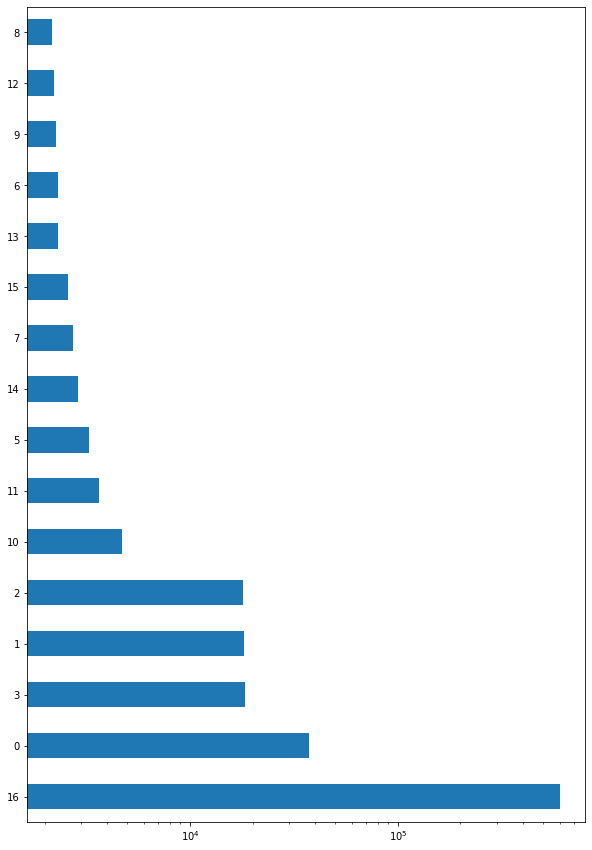

In [31]:
labelled_data['main_label'].value_counts().plot.barh()
fig = plt.gcf()
fig.set_size_inches(10,15)
plt.xscale('log')
plt.show()

In [36]:
sample_df = pd.DataFrame()
for label in range(0,17):
    rnd_idx = random.sample(range(labelled_data[labelled_data['main_label']==label].shape[0]), 2000)
    sample_df = pd.concat([sample_df, labelled_data[labelled_data['main_label']==label].iloc[rnd_idx]], axis=0)
sample_df

,tweet_id,text,hashtags,topic_labels,main_label
43804,1277999605624508417,rt why is mortality from coronavirus dispropor...,['coronavirus'],[0],0
67057,1247854145874333697,rt what are some of the main formats sources a...,['covid19'],[0],0
73289,1263825875449057281,uk borrowing at record high as coronavirus cos...,"['borrowing', 'coronavirus', 'cheshire']",[0],0
27685,1239631753456881666,macron makes his second televised address to t...,['covid19'],[0],0
16455,1280894636127670273,rt thread will the coronavirus force putin to ...,['coronavirus'],[0],0
...,...,...,...,...,...
8930,1168435148523802624,rt attention women in security join and sreels...,"['sreelskshmyp', 'free']",[16],16
18301,1269316742947495941,approximately feet below sea level is a detrit...,['sealifesaturday'],[16],16
69461,953698667680157696,rt panel on secured debt at emceeforum reviewi...,['emceeforum'],[16],16
21649,1192387466759507968,q conf season is here would be great to chat t...,"['uidesign', 'csm', 'engineers']",[16],16


In [37]:
sample_df['main_label'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int64)

In [38]:
grouped = sample_df.groupby('main_label')['text'].agg(' '.join)
grouped


main_label
0     rt why is mortality from coronavirus dispropor...
1     thanks to all who came along to working group ...
2     cisa issued advisory update icsa osisoft pi sy...
3     rt a treviso per parlare di fintech in modo co...
4     rt say more resources needed to prepare for br...
5     israel tech startup nation we re looking for s...
6     china authorities explanation concerning merda...
7     rt don t miss the latest weekly economics podc...
8     here s how to protect yourself from ransomware...
9     looking to speak to people who can t wear face...
10    rt the beirut blast wiped out up to of lebanon...
11    as domestic tourism returns where are the brig...
12    are excited to announce that john king will be...
13    what a reception for the intelligent insurer t...
14    gpif cites study by our head of sustainable fi...
15    russia is unlikely to accept a safe zone contr...
16    rt unbeatableeva was really great to be on a v...
Name: text, dtype: object

In [ ]:
!pip install wordcloud

In [ ]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [ ]:
def wordcloud_plot(text):
    wordcloud = WordCloud(collocations=False, 
                          width = 1000, 
                          height = 700, 
                          background_color ='white', 
                          min_font_size = 10).generate(text)
    
    plt.figure(figsize = (8,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.savefig('image_x.jpeg')
    plt.show()
    

In [ ]:
wordcloud_plot(grouped[0])

In [ ]:
wordcloud_plot(grouped[1])

In [ ]:
wordcloud_plot(grouped[2])

In [ ]:
wordcloud_plot(grouped[3])

In [ ]:
wordcloud_plot(grouped[4])

In [39]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if (len(word) >= min_characters_word) & (word not in stop_words) : tokens.append(word)
#            if (len(word) >= min_characters_word) : tokens.append(word)
    return tokens


# Pre-process training data

Adapted from Martin's code ref:  https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

In [40]:
min_characters_sent = 3   #Min characters in a paragraph (inclusive)
min_characters_word = 3     #Min characters in a word (inclusive)
test_size = 0.2     #Fraction of corpus to keep back for testing

In [41]:
%time labelled_data['tokens'] = labelled_data['text'].apply(lambda x: tokenize_text(str(x)))

Wall time: 2min 39s


In [42]:
train, test = train_test_split(labelled_data[['text', 'main_label', 'tokens']], test_size=test_size, random_state=42)

train_tagged = train.apply(
    lambda r: TaggedDocument(words=r['tokens'], tags=[str(r.main_label)]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=r['tokens'], tags=[str(r.main_label)]), axis=1)

# Apply models

# # Distributed bag of words


In [43]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [44]:
#model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample=0, workers=cores) #Values from tutorial

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=1, min_count=2, sample=0, workers=cores) #My optimised values

model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|█████████████████████████████████████████████████████████████████████| 578212/578212 [00:00<00:00, 2312865.65it/s]


In [45]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████████████████████████████████████████████████████████████████| 578212/578212 [00:00<00:00, 619411.71it/s]


Wall time: 1h 39min 5s


In [46]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [47]:
# Distributed Bag of Words (DBOW) model

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg_dbow = LogisticRegression(n_jobs=1, C=1e5, max_iter=1000)
logreg_dbow.fit(X_train, y_train)
y_pred = logreg_dbow.predict(X_test)
print('xgb_model_dbow Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('xgb_model_dbow Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

MemoryError: Unable to allocate array with shape (300,) and data type float32

# Distributed memory


In [ ]:
#model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=cores, alpha=0.065, min_alpha=0.065)  #Values from tutorial

model_dmm = Doc2Vec(dm=1, dm_mean=0, vector_size=500, window=10, negative=5, min_count=1, workers=cores, alpha=0.1, min_alpha=0) #My optimised values

model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

In [ ]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

In [ ]:
# Distributed Memory (DM) model

y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

logreg_dmm = LogisticRegression(n_jobs=1, C=1e5, max_iter=1000)
logreg_dmm.fit(X_train, y_train)
y_pred = logreg_dmm.predict(X_test)

print('model_dmm Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('model_dmm Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

# Combined model pairing

In [ ]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
model_new = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [ ]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
# Model Pairing method

y_train, X_train = get_vectors(model_new, train_tagged)
y_test, X_test = get_vectors(model_new, test_tagged)
logreg_new = LogisticRegression(n_jobs=1, C=1e5, max_iter=1000)
logreg_new.fit(X_train, y_train)
y_pred = logreg_new.predict(X_test)
print('xgb_model_new Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('xgb_model_new Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

In [ ]:
sim = model_dmm.n_similarity(['covid'], ['coronavirus'])
sim2 = model_dmm.n_similarity(['coronavirus'], ['pandemic'])
sim3 = model_dmm.n_similarity(['coronavirus'], ['cybersecurity'])
sim4 = model_dmm.n_similarity(['cybersecurity'], ['trump'])

print("{:.4f}".format(sim))
print("{:.4f}".format(sim2))
print("{:.4f}".format(sim3))
print("{:.4f}".format(sim4))

In [ ]:
my_list = ['jenkins', 'most', 'popular', 'software', 'deployment', 'server', 'the', 'world', 
                                  'learn', 'from', 'our', 'cto', 'about', 'how', 'hackers', 'look', 'misconfigured',
                                  'jenkins', 'servers', 'for', 'new', 'places', 'attack', 'jenkins', 'cyber',
                                  'insurance', 'cybersecurity', 'atbay']
infer_vector = model_dmm.infer_vector(my_list)

similar_documents = model_dmm.docvecs.most_similar([infer_vector])
similar_documents


# Apply to tweets

In [ ]:
def get_vectors_apply(model, docs_to_classify):
    sents = docs_to_classify.values
    regressors = [model.infer_vector(doc.words, steps=20) for doc in sents]
    return regressors

In [ ]:
def clean_text(text):
    text = re.sub(r"http\S+", "", str(text)) #remove urls
    text = re.sub(r'\S+\.com\S+','',str(text)) #remove urls
    text = re.sub(r'\@\w+','',str(text)) #remove mentions
    text =re.sub(r'\#','',str(text)) #remove hashtags
    text = re.findall(r'[A-Za-z]+',str(text))
    text = ' '.join(text) 
    return text

In [ ]:
src_dir = r'C:\Users\elizabeth\Documents\cleaned tweets\cyber friends tweets'

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))]
classifier_model = logreg_new
model = model_new

with tqdm(total=len(files), desc='Files') as pbar:
    i=0
    for file in files:
        df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        df = df[df.text != '']
        df['clean_tweet'] = df['text'].apply(lambda x: clean_text(x))
        test_tagged = df.apply(
            lambda r: TaggedDocument(words=tokenize_text(r['clean_tweet']), tags=[r.screen_name]), axis=1)
        X_test = get_vectors_apply(model, test_tagged)
        df['y_pred'] = classifier_model.predict(X_test)
        y_pred_score = classifier_model.predict_proba(X_test)
        df2 = pd.DataFrame(y_pred_score)
        df2.columns=classifier_model.classes_
        df2['score'] = df2.max(axis=1)
        df['score'] = df2['score']
        df3 = df[['tweet_id','screen_name', 'text', 'y_pred', 'score']].copy()
        df4 = pd.concat([df3, df2], axis=1)
        df3.to_csv('tweets_trained_topic_modelled_'+str(i)+'.csv', index=False)
        df4.to_csv('tweets_trained_all_topics_modelled_'+str(i)+'.csv', index=False)
        print(df4.head())
        pbar.update(1)
        i = i+1


# How are journalists interests are spread?

first we need to drop the row where the classification has been less than 0.5, then we can pool over user_name

In [ ]:
src_dir = r'C:\Users\elizabeth\Documents\S2DS\tweets_trained_all_topics'

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))]
ls = list(logreg_dbow.classes_)
ls.insert(0, 'screen_name')
df_totalled_topics = pd.DataFrame(columns=ls)

list(df_totalled_topics)

In [ ]:
with tqdm(total=len(files), desc='Files') as pbar:
    for file in files:
        df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        df1 = df.groupby('screen_name')['0', '1', '2','3', '4'].sum()
        df_totalled_topics = pd.concat([df_totalled_topics, df1])
        pbar.update(1)
df_totalled_topics.head()


In [ ]:
df_totalled_topics['total'] = df_totalled_topics.sum(axis = 1)

In [ ]:
df2 = df_totalled_topics[['0', '1', '2','3', '4']].div(df_totalled_topics.total, axis=0)
df2


In [ ]:
df2 = df2.reset_index()
df2 = df2.rename(columns={'index': 'user_name'})
df2 = df2.columns['user_name', 'Covid19', 'A.I.', 'Cybersecurity', 'Financial tech/cyrptocurrency', 'Other']

In [ ]:
topics = [['covid19', 'lockdown', 'coronavirus', 'mentalhealth', 'healthcare'], 
['ai', 'ml', 'dtascience', 'artificalintelligence'], 
['cybersecurity', 'iot', 'robotics', 'infosec'],
['fintech', 'blockchain', 'payments', 'cryptocurrency', 'bitcoin', 'cyrpto']]

In [ ]:
df2.to_csv('user_name_topics_summed.csv', index=False)


In [ ]:
df3 = df2.set_index('user_name')

In [ ]:


x = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
labels = list(df3.columns)
row1 = df3.iloc[0]
row1.plot(kind='bar',title='Oxchich', color='r',stacked=False, figsize=(15,5))





In [ ]:
x = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
labels = list(df3.columns)
row1 = df3.iloc[1]
row1.plot(kind='bar',title='_benkatz', color='r',stacked=False, figsize=(15,5))


In [ ]:
x = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
labels = list(df3.columns)
row1 = df3.iloc[2]
row1.plot(kind='bar',title='_john_handel', color='r',stacked=False, figsize=(15,5))

In [ ]:
x = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
labels = list(df3.columns)
row1 = df3.loc['gcluley']
row1.plot(kind='bar',title='gcluley', color='r',stacked=False, figsize=(15,5))

# Wordclouds for a sense check 

In [ ]:
!pip install wordcloud


In [ ]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [ ]:
def wordcloud_plot(text):
    wordcloud = WordCloud(collocations=False, 
                          width = 1000, 
                          height = 700, 
                          background_color ='white', 
                          min_font_size = 10).generate(text)
    
    plt.figure(figsize = (8,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

In [ ]:
src_dir = r'C:\Users\elizabeth\Documents\S2DS\tweets_trained_topic_modelled'

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))]
with tqdm(total=len(files), desc='Files') as pbar:
    for file in files:
        df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        df1 = df.groupby(['y_pred'])[['text']].sum()
        pbar.update(1)
        



In [ ]:
df1.head(3).style.set_properties(subset=['text'], **{'width':'1000px'})

In [ ]:
wordcloud_plot(df1['text'][0])


In [ ]:
wordcloud_plot(df1['text'][1])

In [ ]:
wordcloud_plot(df1['text'][2])

In [ ]:
wordcloud_plot(df1['text'][3])

In [ ]:
wordcloud_plot(df1['text'][4])

In [ ]:
print(df3['0'].idxmax(), )
print(df3['1'].idxmax(), )
print(df3['2'].idxmax(), )
print(df3['3'].idxmax(), )

In [ ]:
xlabels = [0.0, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7]
labels = ['Covid19', 'A.I.', 'Cybersecurity', 'Finincial technology', 'Other']
row1 = df3.loc['davidjoberly']
fig = row1.plot(kind='barh', color='r',stacked=False, figsize=(15,5))
fig.set_ylabel('Topics', fontsize=30)
fig.set_xlabel('Proportion of tweets', fontsize=30)
fig.set_yticklabels(labels, fontsize=20)
fig.set_xticklabels(xlabels, fontsize=20)
fig.set_title('davidjoberly', fontsize = 30 )
fig.figure.savefig('davidjoberly.png')

In [ ]:
xlabels = [0.0, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7]
labels = ['Covid19', 'A.I.', 'Cybersecurity', 'Finincial technology', 'Other']
row1 = df3.loc['keepnetlabs']
ax = row1.plot(kind='barh', color='r',stacked=False, figsize=(15,5))
ax.set_ylabel('Topics', fontsize=30)
ax.set_xlabel('Proportion of tweets', fontsize=30)
ax.set_yticklabels(labels, fontsize=20)
ax.set_xticklabels(xlabels, fontsize=20)
ax.set_title('keepnetlabs', fontsize = 30 )
fig.figure.savefig('keepnetlabs.jpeg')

In [ ]:
xlabels = [0.0, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7]
labels = ['Covid19', 'A.I.', 'Cybersecurity', 'Finincial technology', 'Other']
row1 = df3.loc['infosec_b']
ax = row1.plot(kind='barh', color='r',stacked=False, figsize=(15,5))
ax.set_ylabel('Topics', fontsize=30)
ax.set_xlabel('Proportion of tweets', fontsize=30)
ax.set_yticklabels(labels, fontsize=20)
ax.set_xticklabels(xlabels, fontsize=20)
ax.set_title('infosec_b', fontsize = 30 )
fig.figure.savefig('infosec_b.jpeg')

In [ ]:
xlabels = [0.0, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7]
labels = ['Covid19', 'A.I.', 'Cybersecurity', 'Finincial technology', 'Other']
row1 = df3.loc['autonofintech']
ax = row1.plot(kind='barh', color='r',stacked=False, figsize=(15,5))
ax.set_ylabel('Topics', fontsize=30)
ax.set_xlabel('Proportion of tweets', fontsize=30)
ax.set_yticklabels(labels, fontsize=20)
ax.set_xticklabels(xlabels, fontsize=20)
ax.set_title('autonofintech', fontsize = 30 )
fig.figure.savefig('autonofintech.jpeg')